# Matrix Factorization - Recommender System for BoardGameGeek #

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


the idea: 
1. every user and game are transformed to a tensor (pytorch array-like object with gradient function ) containing  n  ,choosed in advanced, elements (or factors)
2. each element represents an artificial **latent** feature of this user or game
3. we assume this number of features are enough to distinguish between the users/games

   example features for games: "complexity", "family-oriented" , "story-driven" ,"party driven" and so on...
   example features for user: "loves strategy" , "loves part-games" and so on..
   
   
5. the model gives a random number at first for every feature, which creates a vector that describes the user.
6. in this way we embed each user and game as a n-features vector (factoring)
7. all the users-vectors form a factor matrix and all the games-vectors create a games factors matrix.
8. each vector can be trained - it has weights that can be changed during training process:
9. w1xF1 , w2xF2 , w3xF3 ,..., wnxFn = U1 (user1 vector) 

   w1xF1 , w2xF2 , w3xF3 ,... ,wnxFn = G1 (game1 vector)

   U1@G2 = y  , when y is the rating the user gave for game 1

10. we will also add a bias, beacuse some users might give higher or lower ratings than usual and this constant can adjust the predictions accordingly. 

**So, the ratings y are a dot product of this 2 artifical matrices that were created**


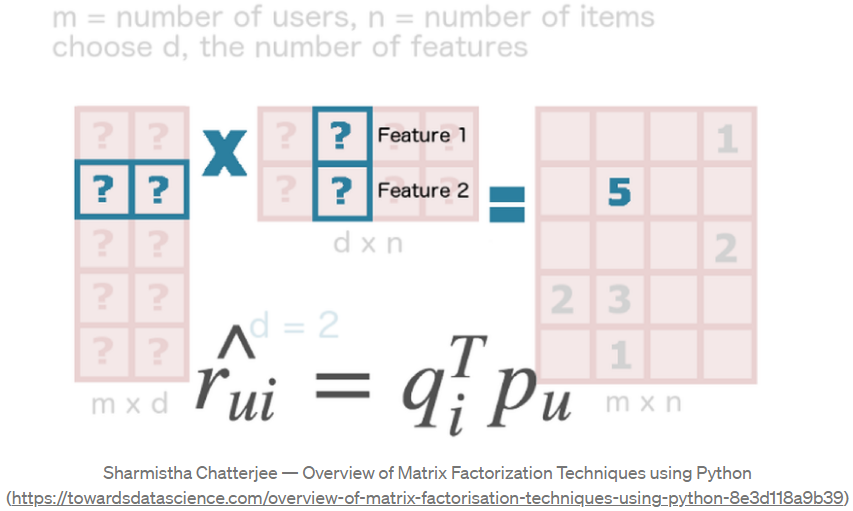

11. we put all user-game pairs in a list and shuffle its order.
12. in first epoch we take one pair , embed them in the n-net and calculate y with the dot-product.
13. we calculate the loss between the expected y and the dot product of two vectors
14. during next epochs the model tries to reach the given y by changing the weights of a user and game
15. this is done by backpropagating (the backward method and then changing the weights with step method)
15. when one of these user-game pair is encountered again, the model will continue its training from the last weights it reached before. and this is the power of the MF.

16. after certain amount of cycles we expect that that each user vector will reach a shape that has meaning, because only certain weights will change and in a certain amount that matches the user preferences. and this can be said for the games-vectors also.

17. the process ends when we cycled through all the pairs.

19. it should be noted: every cycle that calls the model will create the same embeddings over again- they are just used as a dictionary (transforming user and games indices into a n-dimention vectors). the real process in handled by the nn-net that changes the weight given in start of every cycle in order to reach the rating (y) given, therefor changing the vector that is a multiplied by the weight.

20. with the vectors we shaped in the end we can predict all other rartings (by dot-producting everything)

21. train-test split:  it will take place for the users **individually** ,so the last 30% of the every user ratings will be hidden from the training process and will be used as test and validation sets. this fits to the general case and also to a situation that is a time-series one. 

22. In the end of the training process we will calculate errors by looking at the differences between the predicted users-games pivot table, and the original table.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import os
import torch.nn.functional as F
import gc


torch.manual_seed(5)

#cuda = torch.device('cuda')   #enables the use of GPU

# The Model (pytorch nn)

In [ ]:

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=125):#, H1a=10, H1b=10):
        super().__init__()
	# create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors,
                                               sparse=True)
	# create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors,
                                               sparse=True)
    # initialize with positive numbers:
        self.user_factors.weight.data.uniform_(0, 0.5)
        self.item_factors.weight.data.uniform_(0, 0.5)
    
    # create item\user bias embeddings:
        self.user_bias = torch.nn.Embedding(n_users, 1, sparse=True)                                          
        self.item_bias = torch.nn.Embedding(n_items, 1, sparse=True)
    # initialize bias amplitude:                                         
        self.user_bias.weight.data.uniform_(-0.1,0.1)
        self.item_bias.weight.data.uniform_(-0.1,0.1)
                          
    # double linear layer:      -> did not give better results...
        #self.linear_a = torch.nn.Linear(n_factors, H1a) #
        #self.linear_b = torch.nn.Linear(n_factors, H1a) #
               
    def forward(self, user_id, item_id):
        
        bias= self.user_bias(user_id) + self.item_bias(item_id)

        row_factored= self.user_factors(user_id) 
        col_factored= self.item_factors(item_id)
        
        #h1a_relu = F.relu(self.linear_a(row_factored)) #
        #h1b_relu = F.relu(self.linear_b(col_factored)) #
        
             	# matrix multiplication  +bias:

        dot_prod= (row_factored * col_factored).sum(dim=1, keepdim=True)
        #dot_prod= (h1a_relu * h1b_relu).sum(dim=1, keepdim=True)
        
        prediction= (dot_prod+ bias).squeeze()        #removes the batch dimension
        
        return prediction ,row_factored , col_factored

In [ ]:
def set_model (n_users ,n_items, lr=0.009, n_factors=125, weight_decay=0 ,table=None):

    model = MatrixFactorization(n_users, n_items, n_factors= n_factors)#.cuda()

    #model.load_state_dict(torch.load('model_parameters.pt'))

    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    
    # train data is all the non-zeros values
    rows, cols = table.nonzero()# the map (row, col) for all he non-zeros
    p = np.random.RandomState(seed=123).permutation(len(rows)) # all indexes shuffled
    users = rows[p] # users id's in all the non-zero rows by p sorting
    games = cols[p] # games id's in all the non-zero cols by p's sorting
    
    return users, games, model, loss_func, optimizer


In [ ]:
# for a new user with the trained model:
def set_model2 (n_users ,n_items, lr=0.009, n_factors=125, weight_decay=0 ,table=None):

    #model = MatrixFactorization(n_users, n_items, n_factors= n_factors)#.cuda()

    model.load_state_dict(torch.load('model_parameters.pt'))

    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    
    # train data is all the non-zeros values
    rows, cols = table.user.to_numpy(), table['index'].to_numpy() # the map (row, col) for all he non-zeros
    p = np.random.RandomState(seed=123).permutation(len(rows)) # all indexes shuffled
    users = rows[p] # users id's in all the non-zero rows by p sorting
    games = cols[p] # games id's in all the non-zero cols by p's sorting
    
    return users, games, model, loss_func, optimizer

# Used Functions

creating a test table: 
1. find last 30% games of every user (with the help of ranking)
2. take only the games that have more than 10 reviews  (lim parameter)
3. calculate these after substracting the reviews that will be zeroed-out
4. zero-out the rating for those games and try to predict them  later

In [ ]:

def set_test_valid(users, games, table, lim=16 ):
    
    order_table= pd.DataFrame({'user_id':users,'game_id':games})
    
    order_table['ranker']= order_table.reset_index().groupby('user_id')['index'].rank(method='first')
    
    order_table['total_games']=order_table['user_id'].map( order_table.groupby('user_id')['game_id'].count())
    
    order_table['order_precent']=100*(order_table['ranker']/order_table['total_games'])
    
    order_table['is_last_30_prec']= np.where(order_table['order_precent']>=70,1,0)
        
    # test\validation split: last 30% in every user: 15% valid, 15% test:
    
    order_table['is_test']= np.where(order_table['order_precent']>=85,1,0)
    order_table['is_validation']= np.where((order_table['order_precent']>=70) & (order_table['is_test']!=1),1,0)
    
    order_table['rating']= order_table[['user_id','game_id']].apply(lambda x: table[x['user_id'], x['game_id']],axis=1)
    
    order_table['owned']= order_table['game_id'].map(order_table.groupby('game_id')['user_id'].count())
    
    order_table['to_substract_users']= order_table['game_id'].map(order_table[order_table['is_last_30_prec']==1].groupby('game_id')['owned'].count())
    order_table['after_subs']= order_table['owned']-order_table['to_substract_users']
    
    to_zero= order_table[(order_table['is_last_30_prec']==1)\
                         & (order_table['after_subs'] > lim) ][['user_id','game_id','rating', 'is_test', 'is_validation']]   
    
        # test/valid setnp:
    test_set       = to_zero[to_zero['is_test']==1][['user_id','game_id' ]]
    
    validation_set = to_zero[to_zero['is_validation']==1][['user_id','game_id' ]]
        
    table[to_zero['user_id'],to_zero['game_id']] =0
    
    pairs= order_table[(order_table['is_last_30_prec']==0)\
                       | (order_table['after_subs'] <= lim)][['user_id','game_id']]
    users= pairs['user_id'].to_numpy() # test/valid user are filtered from train stage
    games= pairs['game_id'].to_numpy() # test/valid games are filtered from train stage
    
    return users, games, table, to_zero, order_table, validation_set, test_set

The training-loop function using PyTorch: 

In [ ]:

def train_model  (epochs, users, games, optimizer, model , loss_func, table, new, a_rating=None)  : 
    
    list_users= []
    list_games= []
    k=0   
    print('Training on....\n')  
    for row, col in zip(*(users, games)):
        ##print(row,col,"\n")
   
        for i in range(epochs):
            i= i+1
            # Set gradients to zero:
            optimizer.zero_grad()
            
            # Turn data into tensors:
            if new==True:
              rating=  torch.tensor(a_rating[k])  # in case of a new user and trained model
            else:
              rating = torch.tensor([table[row, col]]).type(torch.float32)#.cuda()
            row = torch.LongTensor([row])#.cuda()
            col = torch.LongTensor([col])#.cuda()
        
            # Predict and calculate loss
            prediction ,new_row, new_col = model.forward(row, col)
            loss = loss_func(prediction, rating)
           
            # Backpropagate
            loss.backward()       
            optimizer.step()

            if loss < 0.1  and i > 3:  #early stopping
              break

        r= new_row.detach().numpy().reshape(-1).astype('float32')  #.cpu()
        c= new_col.detach().numpy().reshape(-1).astype('float32')  #.cpu()

        list_users.append(r)
        list_games.append(c)

        if k % 1000 == 0:
          print (len(list_users))
        k=k+1

    table_users= pd.DataFrame(list_users)    
    table_games= pd.DataFrame(list_games) 
    table_users.index= users  
    table_games.index= games  
    
    return table_users, table_games #,model.user_factors.weight.detach().numpy()  #the vectors tables
    #.cpu()


In [ ]:
def get_vectors (table):  # table is a games or users vectors-table which model embedded
    table= table.reset_index()
    
    table=table.rename(columns={'index':'id'})
    
    table['ranking']= table.reset_index().groupby('id')['index'].rank(method='first')

    table['tot_records'] = table['id'].map(table.groupby('id')['ranking'].max())
    
    vectors= table[table['tot_records']== table['ranking'] ].drop(['tot_records', 'ranking'], axis=1).set_index('id')

    return vectors  #returns last vector which is the most updated (more trains)


In [ ]:
def create_predictions (vectors_out_users, vectors_out_games):   # both arrays
    j=0
    predicted_rating=[]
    for i in vectors_out_users :
        prod_list=[]
        for k in vectors_out_games:
            prod= i @ k    # a rating value
            prod_list.append(prod)
            k=k+1
        prod_row =np.array(prod_list)
        #normalizing:
        prod_row_norm= (prod_row/prod_row.max())*10
        #prod_table=pd.Series(np.where(prod_table>10,10,prod_table)).rename(j)
        predicted_rating.append(prod_row_norm)
      
        if j% 100 ==0 :
            print(j)
        j=j+1
        #every iteration creates a row in the prediction table
    predicted_table= np.array(predicted_rating)
    return predicted_table

In [ ]:
def compute_errors_train(table,  origin_table, users, games ,valid_set, test_set, predicted_rating ) :
    # here the zeros in "table" are the test set plus the unknowns
   # we want only to original values taken for train so we put nan in for zeros

    table= table.astype('float32')
    origin_table= origin_table.astype('float32')
    predicted_rating= predicted_rating.astype('float32')

    new_table= np.where(table==0, np.nan, table) 

    new_table_pred= np.where(table==0, np.nan, predicted_rating)

    error_train= np.sqrt((np.nansum( (new_table-new_table_pred)**2))/ (sum(sum(~np.isnan(new_table)))) )
    
    print("\n")
    print("error_train:",error_train)
    
    del new_table
    del new_table_pred
    gc.collect()


In [ ]:

def compute_errors_valid(table,  origin_table, users, games ,valid_set, test_set, predicted_rating ) : 
    
    origin_table[users, games] = 0 #valid set \ test set (after zeroing train)
    origin_table[ test_set['user_id'], test_set['game_id'] ] = 0 #validation set
     # original values that were removed and placed in validation set :
    y_table= np.where(origin_table==0, np.nan, origin_table)
     # predicted values for test set: 
    pred_table= np.where(origin_table==0, np.nan, predicted_rating)      
              
    error= np.sqrt((np.nansum((y_table- pred_table)**2))/ (sum(sum(~np.isnan(y_table)))) )
 
    print("validation error: " ,error)
    
    del origin_table
          

In [ ]:
def compute_errors_test(table,  origin_table2, users, games ,valid_set, test_set, predicted_rating ) : 
    
    origin_table2[users, games] = 0 #valid set \ test set (after zeroing train)
    origin_table2[ valid_set['user_id'], valid_set['game_id'] ] = 0 #test set
     # original values that were removed and placed in validation set :
    y_table= np.where(origin_table2==0, np.nan, origin_table2)
     # predicted values for test set: 
    pred_table= np.where(origin_table2==0, np.nan, predicted_rating)      
              
    error= np.sqrt((np.nansum((y_table- pred_table)**2))/ (sum(sum(~np.isnan(y_table)))) )
 
    print("test error: " ,error)
    
    del origin_table2
        
    return y_table, pred_table

In [ ]:
def evaluate (test_table,test_table_pred ,rec_lim= 7):
    tests=pd.DataFrame(test_table).stack()
    preds=pd.DataFrame(test_table_pred).stack()
    
    comparison= pd.concat([tests ,preds], axis=1)
    
    # 7.5 score is the limit for recommending a game
    comparison['to_recommend']= np.where(comparison[0]>rec_lim,1, 0)
    comparison['did_model_recommend']= np.where(comparison[1]>rec_lim,1, 0)
    comparison['hit']= np.where((comparison['to_recommend']==1) & (comparison['did_model_recommend']==1),1, 0)
    
    recall =( comparison['hit'].value_counts()[1]/ \
                comparison['to_recommend'].value_counts()[1]) *100
    
    comparison['hit_p']= np.where(comparison['to_recommend']==comparison['did_model_recommend'],1, 0)
    
    precision = 100*(comparison['hit'].value_counts()[1]/ comparison['did_model_recommend'].value_counts()[1])
    
    #print(f"\nrecall: {recall}\nprecision: {precision}")
    
    return comparison


In [ ]:
def recommend_to_users(predicted_rating, user_name= None, n=10, users=None ,games=None):
    
    to_recommend= predicted_rating
    
    to_recommend[users,games] =0   # recc
    
    to_recommend= pd.DataFrame(to_recommend ,columns=df_pivot.columns, index=df_pivot.index)
    
    recommend= pd.DataFrame(to_recommend.loc[user_name].sort_values(ascending=False))

    recommend= recommend.join(map_game_name, on='ID')

    recommend_n= recommend.head(n)   
    
    print( "\n",recommend_n['primary'].values)

    return recommend_n

# EDA

Importing the full ratings table. we would like to take only a small but significant portion from it

In [ ]:
path= r'../input/boardgamegeek-reviews/bgg-15m-reviews.csv'

full_df= pd.read_csv(path, index_col=[0])

- more than 15 million (!) records in full ratings table 
-  the average rating and also median is 7.0


In [ ]:
full_df= full_df.drop('comment', axis=1)
full_df['rating'].describe()

checking for nulls ->66 in user name

In [ ]:
cols= full_df.columns

nulls=[]
for col in cols:   
    nulls.append((col, full_df[col].isnull().sum()) )

nulls

Now lest have a look at the ratings-per-user aggregated table:

In [ ]:
rate_per_user= full_df.groupby('user')['rating'].count()
rate_per_user.describe()

In [ ]:

rate_per_user.describe()

count_per_period= pd.cut(rate_per_user, 20)

count_per_period.value_counts()[:12].plot(kind='barh') 

the average is 45 ratings per user, but because of the large std we assume the median- 12 ratings- describes the data much better

most users gave rating for under 300 games, small portion between 300-600 and we can neglect the rest

now lets break-down the main portion- under 300 ratings per user:

In [ ]:
main_counts= rate_per_user[rate_per_user<300]
       
main_per_period= pd.qcut(main_counts , 4)   

main_per_period.value_counts() 

- our model cannot predict without information, so by taking the 11-600 ratings-per-user portion  we include 170,000 users, a very generous and presentetive part of the data- 13.3 million to be (close to) exact


In [ ]:

filtered_table= full_df[ full_df.user.isin(rate_per_user[(rate_per_user>10)&(rate_per_user<601)].index)]
filtered_table.shape

- BUT, since dealing with the given table was a very heavy computational taks ,we only managed to take half a million records. 

# Creating the used table 


*   the loaded table was filtered to include only users with 11 to 600 reviews as seen above
*   we aggregate the table by users count of reviews
*   then we shuffle the aggregated users table
*   using Cumulative sum we can "cut" the table after 800k records   


In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

df= filtered_table.copy()  

del filtered_table

df['ID'].nunique() #19,330 games

df['user'].nunique() #183,492 users

users_id= df['user'].unique() 

games_id= df['ID'].unique() 

rates_per_user= df.groupby('user')['rating'].count()

before= rates_per_user.reset_index()  

after= shuffle(before, random_state= 124).reset_index()

after['cumsum']= after['rating'].cumsum()

lim= 1000000 # for 16 GB RAM the current limit is 500,000 records

after['subst']= after['cumsum']-lim

after['is_pos']= np.where(after['subst']>0, 1, 0)

to_cut= after[after['is_pos']== 1].index[0]

user_list= after[ after.index < to_cut]['user']

df= df[ df['user'].isin(user_list)]

after the cut, the table we will work on has close to 1 million (999,985) records, 13,820 unique users and 
18,636 unique games 

In [ ]:
df # -> 999,985 records!

# Loading Data & Running

we will use two table- the ratings one that we have generated (1 million record)  and the game details table

In [ ]:

df2=  pd.read_csv(r'../input/boardgamegeek-reviews/games_detailed_info.csv')

map_game_name= df2[['id','primary']].set_index('id')

#users_agg= df.groupby('user')['rating'].count()

n_users= 13821                   # 13820 users

n_games= df['ID'].nunique()     #18636 games


df_pivot= df.groupby(['user','ID'] )['rating'].mean().unstack()

df_pivot=df_pivot.fillna(0)

#check=df_pivot.head(10)

table= df_pivot.to_numpy()

valid_table= table.copy()


In [ ]:
del df
del df2
del full_df
gc.collect()

df_pivot.head(5) # this table is what we use to predict!

In [ ]:
new= False  # means using untrained model

#setting-up the factorization model and train-set:
users, games, model, loss_func, optimizer= \
                                    set_model(n_users, n_games ,n_factors=125, weight_decay=0, table=table) 
# search:  n_factors= [50, 100, 150]
                                                                        
#removing 30% of user data for validation and test sets:                                    
users_t, games_t, table, to_zero, order, valid_set, test_set = set_test_valid(users, games, table)


In [ ]:
#training the model:  #epochs =12,  early stopping : 8
table_users, table_games= train_model ( 14, users_t, games_t, optimizer, model , loss_func, table, new) 

#creating a vector table for each game and user after the train:
vectors_out_users= get_vectors(table_users).sort_index().to_numpy()
vectors_out_games= get_vectors(table_games).sort_index().to_numpy()

# with open('vectors.npy', 'wb') as f:
#     np.save(f, vectors_out_users)
#     np.save(f, vectors_out_games)


del table_users
del table_games

gc.collect()

**creating a prdiction table with dot-product of the vectors:**

In [ ]:
#creating a prdiction table with dot-product of the vectors:
print("predicting for...")

with open(r'../input/vectors/vectors.npy', 'rb') as f:
    vectors_out_users = np.load(f)
    vectors_out_games = np.load(f)

predicted_rating= create_predictions (vectors_out_users, vectors_out_games)


In [ ]:
# with open('./the_predictions.npy', 'rb') as f:
#     predicted_rating  = np.load(f)

with open('./the_predictions.npy', 'wb') as f:
    np.save(f, predicted_rating ,allow_pickle=True)
    

# Results

we will compute RMSE for train, validation and test sets:

In [ ]:
#RMSE train, validation and test error:
compute_errors_train(table, valid_table, users_t, games_t, valid_set, test_set, predicted_rating)


In [ ]:
#valid_table2= valid_table.copy()

compute_errors_valid(table, valid_table, users_t, games_t, valid_set, test_set, predicted_rating)


In [ ]:
test_table, test_table_pred= compute_errors_test(table, valid_table, users_t, games_t, valid_set, test_set, predicted_rating)

with open('test_preds.npy', 'wb') as f:
    np.save(f, test_table, allow_pickle=True)
    np.save(f, test_table_pred, allow_pickle=True)

In [ ]:
with open('./test_preds.npy', 'rb') as f:
    test_table  = np.load(f)
    test_table_pred= np.load(f)
    

In [ ]:
rec_lim= 7 #recommendation rating limit score

compare_table= evaluate(test_table, test_table_pred, rec_lim) 


In [ ]:

#recommend top N rated games for a user: 
recommend_n= recommend_to_users(predicted_rating, user_name= 'turtleback', n=10, users=users , games=games)

recommend_n  # top 10 recommendation for user 'Groopy' :


In [ ]:

# compare_table
compare_table.index.set_names(["user_id", "game_id"], inplace=True)
compare_table.columns= ['rating','pred_rating', 'to_recommend', 'did_model_recommend', 'hit_R', 'hit_p']

compare_table.to_csv('compare_table.csv') 

In [ ]:
compare_table.sample(10, random_state=1234)

finally: plotting the predictions vs. the real test ratings, we can see a narrow band around the real ratings. this means our predictions were close, spreaded around the target and most predictions are around rating 7, which make sense given 7 is the average and median rating:

In [ ]:
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

#plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure(figsize=(15, 15))
sns.jointplot(compare_table['pred_rating'],compare_table['rating'],  kind='hex')
plt.show()

# Clustering with Cosine Similarity

-  we will use the vectors we have for games to calaulate cosine distances

- first cosine will be the distance between all vectors and a highly rated war game

- second cosine will be the distance between all vectors and a highly rated party game

- later we will scatter-plot all games by their distance from those two

- The plot will be colored by the game categories (some of which were predicted with another classifier model

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
g_vectors= pd.DataFrame(vectors_out_games.copy())
g_vectors.index= df_pivot.columns

# war game
g_vectors['cosine']= g_vectors.apply(lambda x: pairwise_distances( [g_vectors.loc[163097]],[x],metric='cosine').reshape(-1,1)[0][0],axis=1)

In [ ]:
# party game
g_vectors['cosine2']= g_vectors.apply(lambda x: pairwise_distances( [g_vectors.loc[178900]],[x],metric='cosine').reshape(-1,1)[0][0],axis=1)
# children game
g_vectors['cosine3']= g_vectors.apply(lambda x: pairwise_distances( [g_vectors.loc[17329]],[x],metric='cosine').reshape(-1,1)[0][0],axis=1)
# strategy game
g_vectors['cosine4']= g_vectors.apply(lambda x: pairwise_distances( [g_vectors.loc[167791]],[x],metric='cosine').reshape(-1,1)[0][0],axis=1)


In [ ]:
g_vectors.sort_values(by='cosine', ascending=True)

In [ ]:
cats_table= pd.read_csv(r'../input/games-cat/games_categ.csv', index_col=[1])
cats_table.columns=['Unnamed: 0', 'primary', 'cat']
g_vectors= g_vectors.join(cats_table[['primary','cat']])

In [ ]:
g_vectors.cat.value_counts().plot(kind='bar')  # after classification filling with a model
# the original table had more war-games than any other category!

In [ ]:
g_vectors['rank']= g_vectors.groupby('cat')['cosine'].rank(method= 'min')
war_games= g_vectors[ (g_vectors['rank']<3000)& (g_vectors['cat']=='War')].iloc[:,-12:]

In [ ]:
g_vectors['rank2']= g_vectors.groupby('cat')['cosine2'].rank(method= 'min')
party_games= g_vectors[ (g_vectors['rank']<1000)& (g_vectors['cat']=='Party')].iloc[:,-12:]

g_vectors['rank4']= g_vectors.groupby('cat')['cosine'].rank(method= 'min')
strategy_games= g_vectors[ (g_vectors['rank']<1000)& (g_vectors['cat']=='Strategy')].iloc[:,-12:]

g_vectors['rank3']= g_vectors.groupby('cat')['cosine2'].rank(method= 'min')
children_games= g_vectors[ (g_vectors['rank']<1000)& (g_vectors['cat']=='Children')].iloc[:,-12:]

g_vectors['rank5']= g_vectors.groupby('cat')['cosine2'].rank(method= 'min')
family_games= g_vectors[ (g_vectors['rank']<1000)& (g_vectors['cat']=='Family')].iloc[:,-12:]

g_vectors['rank6']= g_vectors.groupby('cat')['cosine'].rank(method= 'min')
abstract_games= g_vectors[ (g_vectors['rank']<1000)& (g_vectors['cat']=='Abstract')].iloc[:,-12:]


using plotly, we can zoom-in and look for games that are similar (If the model did a good job, this means close markers) 

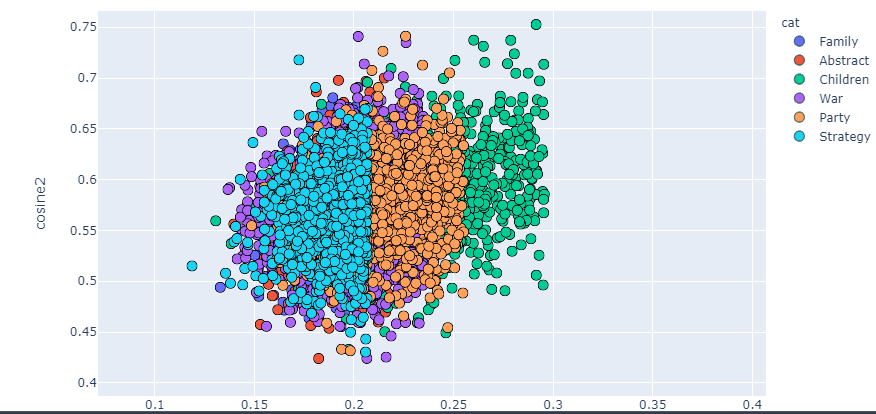

In [ ]:
import plotly.express as px
clust= pd.concat([family_games, abstract_games, children_games, war_games ,party_games,strategy_games, ])

fig = px.scatter(clust, x="cosine", y="cosine2",
                 color="cat", 
                 hover_data=['primary'])

fig.update_traces(marker=dict(size=10,
                              line=dict(width=0.8,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()